#Classifcation Problem: English difficulty of movies based on subtitles (Apiary Project)

## Introduction

Hello and welcome to my take on this project launched by the Apiary Team at Practicum by Yandex! This project is part of my learning path as a Data Scientist at Practicum USA Bootcamp.

English is one of the most spoken languages worldwide, that's not a secret to anybody. As present as it is on the internet, learning it can still be a challenging task for natives of different languages. A fun way to improve listening skills and familiarize with a language could be watching movies and TV series with subtitles, but how much English is too much English?

Being a linguist enthusiast myself and an intermediate Chinese speaker, I know that choosing the right show to watch in a second language can be challenging! It would be great to know how do vocabulary and grammar used in a show compare to my current skills, otherwise things cat get frustrating when each new sentence needs to be paused to look up the meaning of a sentence.

In this project we seek to develop a classification model to decide on movie difficulty based on subtitles. It works by checking English words in a subtitle file and trying to predict how would a professional linguist classify it based on its difficulty. The levels range A2 to B2, based on the English CEFR (Common European Framework of Reference for Languages).

Enjoy!

## Importing modules

In [1]:
#@title
!pip install pysrt
!pip install spacy
!pip install catboost

# Import Modules
import pysrt
import os, time, glob
import pandas as pd
import numpy as np
import re
import string
import spacy
import nltk
nltk.download('omw-1.4')
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Apiary
!ls

/content/drive/MyDrive/Apiary
'10_Cloverfield_lane(2016).srt'			     'Mamma_Mia(2008).srt'
'10_things_I_hate_about_you(1999).srt'		     'Mary_Poppins_returns(2018).srt'
 A1.txt						     'Matilda(1996).srt'
 A2.txt						     'Meet_the_parents(2000).srt'
'A_knights_tale(2001).srt'			      ML_Movie_Difficulty_Predictions.ipynb
'Aladdin(1992).srt'				     'Moulin_Rouge(2001).srt'
'All_dogs_go_to_heaven(1989).srt'		      movie_analysis.joblib
'An_American_tail(1986).srt'			      movie_df.joblib
'A_star_is_born(2018).srt'			     'Mrs_Doubtfire(1993).srt'
 B1.txt						     'My_big_fat_Greek_wedding(2002).srt'
 B2_alt.txt					     'Notion Suggested Movie Levels.xlsx'
 B2.txt						     'Notting_Hill(1999).srt'
'Babe(1995).srt'				      Oxford_C_Level.parquet
'Back_to_the_future(1985).srt'			      Oxford_Data.parquet
'Batman_begins(2005).srt'			     'Pirates_of_the_Caribbean(2003).srt'
'Beauty_and_the_beast(2017).srt'		     'Pleasantville(1998).srt'
'Before_I_go_to_sleep(2014).srt'		     'Powde

## Reading target data

First we will check what data is available from the linguists, which is a table about the movies and respective CEFR levels!

In [3]:
target_table = pd.read_excel('Notion Suggested Movie Levels.xlsx')
target_table.head()

,Movie,Level,Subtitles,Kinopoisk
0,10 Cloverfield Lane,B1,Yes,NaN
1,10 things I hate about you,B1,Yes,No subs
2,A knight’s tale,B2,Yes,Everything
3,A star is born,B2,Yes,Nope
4,Aladdin,A2/A2+,Yes,Everything


In [4]:
target_table.shape[0]

88

In [5]:
# Data if subtitles are available or not is not important
# we should check if they actually are available
target_df = target_table[['Movie', 'Level']]

del target_table

Data from 88 movies is available. This data will be split between training and testing to be used as learning material for our prediction model!

## Reading wordlists

A good starting point to classify movie difficulties based on their subtitles is to analyze vocabulary. For that, we will use Oxford and Cambridge wordlists previously scraped from the internet to create a word reference table!

In [6]:
!ls

'10_Cloverfield_lane(2016).srt'			     'Mamma_Mia(2008).srt'
'10_things_I_hate_about_you(1999).srt'		     'Mary_Poppins_returns(2018).srt'
 A1.txt						     'Matilda(1996).srt'
 A2.txt						     'Meet_the_parents(2000).srt'
'A_knights_tale(2001).srt'			      ML_Movie_Difficulty_Predictions.ipynb
'Aladdin(1992).srt'				     'Moulin_Rouge(2001).srt'
'All_dogs_go_to_heaven(1989).srt'		      movie_analysis.joblib
'An_American_tail(1986).srt'			      movie_df.joblib
'A_star_is_born(2018).srt'			     'Mrs_Doubtfire(1993).srt'
 B1.txt						     'My_big_fat_Greek_wedding(2002).srt'
 B2_alt.txt					     'Notion Suggested Movie Levels.xlsx'
 B2.txt						     'Notting_Hill(1999).srt'
'Babe(1995).srt'				      Oxford_C_Level.parquet
'Back_to_the_future(1985).srt'			      Oxford_Data.parquet
'Batman_begins(2005).srt'			     'Pirates_of_the_Caribbean(2003).srt'
'Beauty_and_the_beast(2017).srt'		     'Pleasantville(1998).srt'
'Before_I_go_to_sleep(2014).srt'		     'Powder(1995).srt'
'Before_sunrise(1

In [7]:
# Here we will read the Oxford wordlists to create our word reference table

# This part of the code will reset the cell result if it is ran more than once
try:
    del A1, A2, B1, B2, B2_alt, C1, df
except:
    pass

# Let's read each txt file from the folder
for wordlist_name in glob.glob('*.txt'):
  # Open each file in read mode
  with open(wordlist_name, 'r') as f:
    # Read the first line, which contains the current txt file level
    level = f.readline()[1:3]

    # Print the txt file currently being read
    print(f'Creating {level} df')

    # Create the df structure to create the ref table for the current txt file
    df = {
        'word': [],
        'pos': []
    }

    # Let's read each line!
    for line in f:
      # First split text into a list and strip unwanted characters
      split_line = re.split(r'\s|/', line)
      # The first element of the list is always the word, so we'll keep that
      df['word'].append(split_line[0].rstrip('.,/ '))
      stripped = [i.rstrip('.,/ ') for i in split_line[1:]]
      # Check the description the word, which is also in the wordlist
      # Also do a regex with all the POS available in the wordlist (backlogging)
      df['pos'].append( re.sub('[^A-z ]', '', ' '.join(
          set([ i for i in stripped if i in ['n', 'adj', 'v', 'det', 'adv', 'exclam', 'pron', 'prep', 'conj', 'number', 'article']]) ) ) )
    # Close the current file
    f.close()

    # If there isn't a variable with the current level, create a df!
    if level not in locals():
      locals()[level] = pd.DataFrame(df)
    # If there actually is a variable with the current level, add _alt
    # I've done it primarily because there are two *.txt files for B2
    else:
      locals()[level + '_alt'] = pd.DataFrame(df)

del level, line, split_line, stripped, wordlist_name

Creating A1 df
Creating A2 df
Creating B1 df
Creating B2 df
Creating B2 df
Creating C1 df


In [8]:
# Concatenate both B2 dfs into a single B2 df
B2 = pd.concat([B2, B2_alt], join='outer')

# Let's create a single df with word references
word_df = pd.DataFrame(data=[], columns=['word', 'pos', 'level'])

word_df.head()

,word,pos,level


In [9]:
levels = ['A1', 'A2', 'B1', 'B2', 'C1']

# Add the levels column with the level for each row
for level in levels:
    locals()[level]['level'] = level
    word_df = pd.concat([word_df, locals()[level]])

word_df = word_df.reset_index(drop=True)

del A1, A2, B1, B2, B2_alt, C1

# Let's check if any wordd were left with empty POS
word_df[word_df['pos'] == '']

,word,pos,level
798,infinitive,,A1
1152,expert,,A2


In [10]:
# It only happened to a few, so we can manually add these
word_df.iloc[798][1] = 'n'
word_df.iloc[1152][1] = 'n adj'
word_df[word_df['pos'] == ''].shape[0]

0

In [11]:
# Let's check parts of speech unique values for artifacts
pos_array = word_df['pos'].unique()

pos_list = []

for pos in pos_array:
    pos = pos.split(' ')
    for i in pos:
        pos_list.append(i)

pos_list = list(set(pos_list))
display(np.array(pos_list))

del pos_array

array(['prep', 'n', 'adv', 'conj', 'number', 'pron', 'v', 'det', 'adj',
       'exclam', 'article'], dtype='<U7')

In [12]:
# Since we will use spacy, it's better to translate these pos to spacy format

pos_dict = {
    'v': 'VERB',
    'exclam': 'INTJ',
    'prep': 'SCONJ',
    'n': 'NOUN',
    'number': 'NUM',
    'article': 'DET',
    'det': 'DET',
    'adj': 'ADJ',
    'conj': 'CONJ',
    'pron': 'PRON',
    'adv': 'ADV'
    }

def translate_pos(wrong_pos):
    line = wrong_pos.split(' ')
    line = pd.Series(line).map(pos_dict, na_action='ignore')
    if line.isna().sum() > 0:
        print('NaN found, dict does not map all values')
        line = line.dropna()
    line = ' '.join(list(line.values))
    return line

word_df['pos'] = word_df['pos'].apply(translate_pos)

# Let's check for duplicated words!
word_df[ word_df['word'].duplicated(keep=False) ].sort_values('word')

,word,pos,level
2542,academic,NOUN,B2
1733,academic,ADJ,B1
2545,account,VERB,B2
1736,account,NOUN,B1
3257,acid,NOUN,B2
...,...,...,...
5242,well,NOUN,C1
1726,while,CONJ,A2
2522,while,NOUN,B1
2523,whole,NOUN,B1


In [13]:
print(word_df.shape[0])
word_df.head()

5263


,word,pos,level
0,a,DET,A1
1,about,SCONJ ADV,A1
2,above,SCONJ ADV,A1
3,across,SCONJ ADV,A1
4,action,NOUN,A1


In [14]:
oxford = word_df

word_df = pd.read_html('full.html')[0]
word_df.head()

,Base Word,Guideword,Level,Part of Speech,Topic,Details
0,cattle,NaN,B1,NaN,animals,Details
1,clothes,NaN,A1,NaN,clothes,Details
2,albeit,NaN,C2,NaN,NaN,Details
3,although,BUT,B1,NaN,communication,Details
4,although,DESPITE,B1,NaN,communication,Details


In [15]:
word_df = word_df[['Base Word', 'Part of Speech', 'Level']]
word_df.columns = ['word', 'pos', 'level']
word_df = word_df.sort_values('level', ascending=False).reset_index(drop=True)
word_df.head()

,word,pos,level
0,donor,noun,C2
1,classical,adjective,C2
2,broadminded,adjective,C2
3,crackdown,noun,C2
4,crack,noun,C2


In [16]:
word_df = word_df.loc[word_df[['word', 'pos']].duplicated() == False]
print(word_df.shape[0])
word_df.head()

1928


,word,pos,level
0,donor,noun,C2
1,classical,adjective,C2
2,broadminded,adjective,C2
3,crackdown,noun,C2
4,crack,noun,C2


In [17]:
word_df = word_df.loc[word_df[['word', 'level']].duplicated() == False]
print(word_df.shape[0])
word_df.head()

1854


,word,pos,level
0,donor,noun,C2
1,classical,adjective,C2
2,broadminded,adjective,C2
3,crackdown,noun,C2
4,crack,noun,C2


In [18]:
pos_dict = {
    'noun': 'NOUN',
    'adjective': 'ADJ',
    'adverb': 'ADV',
    'verb': 'VERB',
    'pronoun': 'PRON',
    'preposition': 'SCONJ',
    'determiner': 'DET',
    'auxiliary verb': 'AUX',
    'modal verb': 'VERB',
    'exclamation': 'INTJ'
    }

word_df['pos'] = word_df['pos'].map(pos_dict)
word_df.head()

<ipython-input-18-4cb24d2574a6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  word_df['pos'] = word_df['pos'].map(pos_dict)


,word,pos,level
0,donor,NOUN,C2
1,classical,ADJ,C2
2,broadminded,ADJ,C2
3,crackdown,NOUN,C2
4,crack,NOUN,C2


In [19]:
word_df.shape[0]

1854

In [20]:
word_df['word'] = word_df['word'].apply(lambda x: None if ' ' in x else x)
word_df = word_df[word_df['word'].notna()]
word_df = word_df.merge(oxford, how='outer', on=['word', 'pos'])
word_df

,word,pos,level_x,level_y
0,donor,NOUN,C2,C1
1,classical,ADJ,C2,A2
2,broadminded,ADJ,C2,NaN
3,crackdown,NOUN,C2,NaN
4,crack,NOUN,C2,NaN
...,...,...,...,...
6015,worthwhile,ADJ,NaN,C1
6016,worthy,ADJ,NaN,C1
6017,yell,VERB,NaN,C1
6018,yield,NOUN VERB,NaN,C1


In [21]:
word_df['level'] = word_df['level_x'].fillna(word_df['level_y'])
word_df = word_df.drop(['level_x', 'level_y'], axis=1)
print(word_df.shape[0])
word_df[word_df['word'].duplicated(keep=False)].sort_values('word')

6020


,word,pos,level
1818,about,SCONJ ADV,A1
732,about,ADV,B2
141,above,ADV,C2
1819,above,SCONJ ADV,A1
4932,abuse,NOUN VERB,C1
...,...,...,...
3172,while,CONJ,A2
3798,while,NOUN,B1
1093,while,NaN,B2
3173,whole,ADJ,A2


In [22]:
word_df2 = word_df.sort_values('level', ascending=False)
word_df2 = word_df2.loc[ word_df2['word'].duplicated() ].copy()
word_df = word_df.dropna()

known_words = word_df['word'].values
known_words_pos = word_df['pos'].values
known_words_levels = word_df['level'].values

known_words2 = word_df2['word'].values
known_Words_levels2 = word_df2['level'].values

find_word_dict = {}
find_word_dict2 = {}
repeated_words = []

print('Creating lookup table to define word levels in movies...', end = '\n\n')

for i in range(len(known_words)):
    for pos in known_words_pos[i].split(' '):
        try:
            find_word_dict[(known_words[i], pos)]
            repeated_words.append(known_words[i])
            find_word_dict[(known_words[i], pos)] = known_words_levels[i]
        except:
            find_word_dict[(known_words[i], pos)] = known_words_levels[i]


for i in range(len(known_words2)):
    find_word_dict2[known_words[i]] = known_words_levels[i]

del known_words, known_words_pos, known_words_levels

def find_word_level(row):
    lemma = row['lemma']
    pos = row['pos']
    try:
        result = find_word_dict[(lemma, pos)]
    except:
        try:
            result = find_word_dict2[lemma]
        except:
            result = 'Unk'
    return result

print(f'The following words are repeated for same POS in the wordlists: {repeated_words}')

Creating lookup table to define word levels in movies...

The following words are repeated for same POS in the wordlists: ['bank', 'any', 'about', 'above', 'across', 'answer', 'around', 'back', 'back', 'behind', 'below', 'black', 'blue', 'blue', 'break', 'brown', 'brown', 'call', 'capital', 'change', 'clean', 'clean', 'cold', 'complete', 'cost', 'cost', 'dance', 'design', 'design', 'dress', 'dress', 'drink', 'east', 'email', 'email', 'end', 'exercise', 'have', 'have', 'ice', 'need', 'after', 'all', 'alone', 'along', 'anywhere', 'arrangement', 'assistant', 'attack', 'attention', 'average', 'average', 'before', 'best', 'blank', 'bottom', 'brush', 'camp', 'camp', 'care', 'care', 'cause', 'cause', 'chat', 'circle', 'circle', 'control', 'control', 'copy', 'cross', 'cross', 'cycle', 'cycle', 'download', 'dream', 'expert', 'light', 'rest', 'ring', 'rock', 'access', 'access', 'aim', 'arrest', 'arrest', 'balance', 'ban', 'base', 'bend', 'bite', 'bite', 'block', 'bomb', 'brand', 'calm', 'campaig

In [23]:
find_word_dict

{('donor', 'NOUN'): 'C2',
 ('classical', 'ADJ'): 'C2',
 ('broadminded', 'ADJ'): 'C2',
 ('crackdown', 'NOUN'): 'C2',
 ('crack', 'NOUN'): 'B2',
 ('allied', 'ADJ'): 'C2',
 ('chancellor', 'NOUN'): 'C2',
 ('centre', 'NOUN'): 'C2',
 ('count', 'NOUN'): 'C2',
 ('corner', 'NOUN'): 'C2',
 ('central', 'ADJ'): 'C2',
 ('anonymous', 'ADJ'): 'C2',
 ('bond', 'VERB'): 'C2',
 ('contact', 'NOUN'): 'B1',
 ('constraint', 'NOUN'): 'C2',
 ('compliment', 'NOUN'): 'C2',
 ('comeback', 'NOUN'): 'C2',
 ('enquiry', 'NOUN'): 'C2',
 ('attainable', 'ADJ'): 'C2',
 ('accountable', 'ADJ'): 'C2',
 ('accessible', 'ADJ'): 'C2',
 ('cast', 'VERB'): 'B2',
 ('cricket', 'NOUN'): 'C2',
 ('automatic', 'ADJ'): 'C2',
 ('deterrent', 'NOUN'): 'C2',
 ('ambiguous', 'ADJ'): 'C2',
 ('anchor', 'VERB'): 'C2',
 ('descendant', 'NOUN'): 'C2',
 ('deposit', 'NOUN'): 'C2',
 ('clutch', 'VERB'): 'C2',
 ('blow', 'VERB'): 'C2',
 ('carve', 'VERB'): 'C2',
 ('adolescent', 'NOUN'): 'C2',
 ('cushion', 'NOUN'): 'C2',
 ('abusive', 'ADJ'): 'C2',
 ('aspirati

In [24]:
find_word_dict2

{'donor': 'C2',
 'classical': 'C2',
 'broadminded': 'C2',
 'crackdown': 'C2',
 'crack': 'C2',
 'allied': 'C2',
 'chancellor': 'C2',
 'centre': 'C2',
 'count': 'C2',
 'corner': 'C2',
 'central': 'C2',
 'anonymous': 'C2',
 'bond': 'C2',
 'contact': 'C2',
 'constraint': 'C2',
 'compliment': 'C1',
 'comeback': 'C2',
 'enquiry': 'C2',
 'attainable': 'C2',
 'accountable': 'C2',
 'accessible': 'C2',
 'cast': 'C2',
 'cricket': 'C2',
 'automatic': 'C2',
 'deterrent': 'C2',
 'ambiguous': 'C2',
 'anchor': 'C2',
 'descendant': 'C2',
 'deposit': 'C1',
 'clutch': 'C1',
 'blow': 'C2',
 'carve': 'C2',
 'adolescent': 'C2',
 'cushion': 'C2',
 'abusive': 'C2',
 'aspiration': 'C2',
 'charisma': 'C2',
 'characteristic': 'C2',
 'casual': 'C2',
 'coral': 'C2',
 'craziness': 'C2',
 'concentration': 'C2',
 'awkward': 'C2',
 'erosion': 'C2',
 'elimination': 'C2',
 'bronze': 'C2',
 'abuse': 'C2',
 'distinction': 'C2',
 'arid': 'C2',
 'bid': 'C2',
 'arrival': 'C2',
 'alliance': 'C2',
 'consultation': 'C2',
 'cons

By the end of this section, we have python dictionaries with words and their respective parts of speech. This is important because different parts of speech may define different levels for the same word! An additional dictionary has been created for cases where the part of speech is not correctly recognized.

## Reading subtitle files

Now subtitle files will be read and organized into tables by lines. This data will be used for later analysis for each movie.

In [25]:
# Let's get ready to parse subtitle files
# First let's create the general structure of a table
srt_list = glob.glob('*.srt')

srt_table = {
    'name': [],
    'year': [],
    'filename': [],
}
for filename in srt_list:
    srt_table['name'].append(filename[:-10].lower())
    srt_table['year'].append(filename[-9:-5])
    srt_table['filename'].append(filename)

del filename, srt_list

# The table has each movie's name, year, filename and word counts by level
srt_ref = pd.DataFrame(srt_table)
display(srt_ref)

del srt_table

,name,year,filename
0,mamma_mia,2008,Mamma_Mia(2008).srt
1,die_hard,1988,Die_hard(1988).srt
2,the_blind_side,2009,The_blind_side(2009).srt
3,the_theory_of_everything,2014,The_theory_of_everything(2014).srt
4,the_secret_life_of_walter_mitty,2013,The_secret_life_of_Walter_Mitty(2013).srt
...,...,...,...
81,pleasantville,1998,Pleasantville(1998).srt
82,the_invisible_man,2020,The_invisible_man(2020).srt
83,back_to_the_future,1985,Back_to_the_future(1985).srt
84,notting_hill,1999,Notting_Hill(1999).srt


In [26]:
# Before we start we should check for aliens in movie names
display( srt_ref[srt_ref['name'].duplicated(keep=False)] )
srt_ref['name'].unique()
# Looks good! No duplicates and neat movie names

,name,year,filename


array(['mamma_mia', 'die_hard', 'the_blind_side',
       'the_theory_of_everything', 'the_secret_life_of_walter_mitty',
       'the_man_called_flintstone', 'the_hangover', 'up', 'titanic',
       'ready_or_not', 'dredd', 'the_fault_in_our_stars',
       'it_s_a_wonderful_life', 'groundhog_day', 'good_will_hunting',
       'venom', 'the_terminator', 'the_terminal', 'pulp_fiction',
       'finding_nemo', 'lion', 'babe', 'catch_me_if_you_can', 'toy_story',
       'soul', 'pirates_of_the_caribbean', 'the_kings_speech',
       'the_break-up', 'aladdin', 'home_alone', 'shrek', 'knives_out',
       'braveheart', 'inside_out', 'an_american_tail', 'meet_the_parents',
       'the_lion_king', 'dune', 'moulin_rouge', 'we_are_the_millers',
       'the_usual_suspects', 'the_jungle_book', 'before_sunset',
       'love_actually', 'the_lord_of_the_rings', 'the_graduate', 'logan',
       'matilda', 'the_holiday', 'mary_poppins_returns',
       'eurovision_song_contest_', 'mrs_doubtfire', 'house_of_gucci

In [27]:
%%time

# Let's get natural language ready
nlp = spacy.load('en_core_web_sm')

# Let's create a translator to remove punctuation when parsing
trans = str.maketrans('', '', string.punctuation)

try:
    movie_analysis = joblib.load('movie_analysis.joblib')
except:
    # Dict to store all results!
    movie_analysis = {}

    # Loop through each movie's subtitle to parse it!
    for movie_index in range(len(srt_ref['filename'])):

        movie_filename = srt_ref['filename'][movie_index]

        movie_name = srt_ref['name'][movie_index]

        # Open the SRT file
        full_subtitles = pysrt.open(movie_filename)
        # movie is now a giant string of the whole subtitles text

        single_analysis = {
            'lemma': [],
            'pos': [],
            'line': [],
            'start': [],
            'end': []
        }

        # Create a counter to identify strings
        line = 0

        # Check each line for the movies subtitle
        for subtitles in full_subtitles:
            line = line + 1

            # Retrieve the time of single line
            start_time = subtitles.start.to_time()
            end_time = subtitles.end.to_time()

            # Retrieve the text of single line
            subtitles_text = subtitles.text

            # The following part tries to remove aliens from subtitle text
            except_list = re.findall("<['\'A-z\/]+>", subtitles_text)
            for i in except_list:
                subtitles_text = subtitles_text.replace(i, ' ')

            # Let's use the translator to remove punctuationsm, then lower
            subtitles_text = subtitles_text.translate(trans).lower()

            # Here the parsing actually starts, we're using spacy!
            doc = nlp(subtitles_text)

            # Loop through the tokens created by spacy
            for token in doc:

                # Retrieve Lemma and POS
                lemma = token.lemma_
                pos = token.pos_

                single_analysis['lemma'].append(lemma)
                if pos == 'PNOUN':
                    pos = 'NOUN'
                single_analysis['pos'].append(pos)
                single_analysis['line'].append(line)
                single_analysis['start'].append( start_time.hour * 3600 + start_time.minute * 60 + start_time.second )
                single_analysis['end'].append( start_time.hour * 3600 + start_time.minute * 60 + start_time.second )

            movie_analysis[movie_name] = single_analysis

    joblib.dump(movie_analysis, 'movie_analysis.joblib')
    del start_time, end_time, lemma, pos, doc, subtitles_text, i, except_list, line, single_analysis, full_subtitles, movie_name, movie_filename, movie_index


CPU times: user 11 s, sys: 390 ms, total: 11.4 s
Wall time: 19.2 s


In [28]:
print('Word table for movie "The Blind Side"')
pd.DataFrame(movie_analysis['the_blind_side']).head()

Word table for movie "The Blind Side"


,lemma,pos,line,start,end
0,crowd,NOUN,1,29,29
1,cheer,VERB,1,29,29
2,in,ADP,1,29,29
3,distance,NOUN,1,29,29
4,lelgh,PROPN,2,32,32


Tables have been created, one for each movie. Each of these tables contain all words, their respective parts of speech, what line they are in and what time of the movie they appear. A full list of all available movies is shown below:

In [29]:
list(srt_ref['name'].unique())

['mamma_mia',
 'die_hard',
 'the_blind_side',
 'the_theory_of_everything',
 'the_secret_life_of_walter_mitty',
 'the_man_called_flintstone',
 'the_hangover',
 'up',
 'titanic',
 'ready_or_not',
 'dredd',
 'the_fault_in_our_stars',
 'it_s_a_wonderful_life',
 'groundhog_day',
 'good_will_hunting',
 'venom',
 'the_terminator',
 'the_terminal',
 'pulp_fiction',
 'finding_nemo',
 'lion',
 'babe',
 'catch_me_if_you_can',
 'toy_story',
 'soul',
 'pirates_of_the_caribbean',
 'the_kings_speech',
 'the_break-up',
 'aladdin',
 'home_alone',
 'shrek',
 'knives_out',
 'braveheart',
 'inside_out',
 'an_american_tail',
 'meet_the_parents',
 'the_lion_king',
 'dune',
 'moulin_rouge',
 'we_are_the_millers',
 'the_usual_suspects',
 'the_jungle_book',
 'before_sunset',
 'love_actually',
 'the_lord_of_the_rings',
 'the_graduate',
 'logan',
 'matilda',
 'the_holiday',
 'mary_poppins_returns',
 'eurovision_song_contest_',
 'mrs_doubtfire',
 'house_of_gucci',
 'forrest_gump',
 'before_sunrise',
 'bridget_jon

## Merging ref tables

After reading subtitle files available, we will join information of tables to make sure data is available for each movie analyzed. During this section, we will also standardize levels for classification.

In [30]:
# Printing the word ref DF
word_df.head()

,word,pos,level
0,donor,NOUN,C2
1,classical,ADJ,C2
2,broadminded,ADJ,C2
3,crackdown,NOUN,C2
4,crack,NOUN,C2


In [31]:
# Print the ref table of targets
target_df.head()

,Movie,Level
0,10 Cloverfield Lane,B1
1,10 things I hate about you,B1
2,A knight’s tale,B2
3,A star is born,B2
4,Aladdin,A2/A2+


In [32]:
target_df['Level'].unique()

array(['B1', 'B2', 'A2/A2+', 'B1,B2', 'A2/A2+,B1'], dtype=object)

In [33]:
target_df.loc[:, 'Level'] = target_df['Level'].replace({'A2/A2+': 'A2', 'B1,B2': 'B2', 'A2/A2+,B1': 'B1'}).values

In [34]:
target_df['Level'].unique()

array(['B1', 'B2', 'A2'], dtype=object)

In [35]:
def lower_remove_quotes( input_string ):
    replacelist = ['’', '.' , ',' , '!' , '?', ':']
    output = input_string.lower().replace(' ', '_')
    for i in replacelist:
        output = output.replace(i, '')
    return output

# first let's remove punctuation marks
target_df.loc[:, 'Movie']= target_df.apply(lambda x: lower_remove_quotes(x['Movie']), axis=1).values
target_df.head()

,Movie,Level
0,10_cloverfield_lane,B1
1,10_things_i_hate_about_you,B1
2,a_knights_tale,B2
3,a_star_is_born,B2
4,aladdin,A2


In [36]:
target_df_backup = target_df.copy()

In [49]:
# Then we will loop through each movie with subtitle
movie_array = srt_ref['name'].values
target_df_movies = target_df['Movie'].values

def find_movie(input_string):
      # for each movie with subtitle, check if the movie is in the ref
      output = [movie for movie in movie_array if movie in input_string]
      if len(output) == 0:
          return 'Unknown'
      if len(output) >  1:
          output = [max(output, key=len)]
      return output[0]

movie_names = []
for i in range(len(target_df_movies)):
    movie = target_df_movies[i]
    movie = find_movie(movie)
    movie = re.findall('[-_A-z0-9]+', movie)[0].strip('_')
    movie_names.append(movie)

In [50]:
target_df.loc[:, 'name'] = movie_names

In [55]:
target_df.columns = [str.lower(column) for column in target_df.columns]

In [56]:
target_df.columns = target_df[['name', 'level']]
test = target_df.merge(srt_ref, how='outer', on='name')

In [57]:
display(test[ test['filename'].isna() ])

,movie,level,name,year,filename
6,an__american_tail,A2,Unknown,NaN,NaN
7,harry_potter_(1),B1,Unknown,NaN,NaN
8,its_a_wonderful_life,A2,Unknown,NaN,NaN
9,lie_to_me_(series),B2,Unknown,NaN,NaN
10,the_man_called_flinstone,A2,Unknown,NaN,NaN
11,the_walking_dead__(series)🧟,A2,Unknown,NaN,NaN
12,were_the_millers,B1,Unknown,NaN,NaN
29,eurovision_song_contest_the_story_of_fire_saga,A2,eurovision_song_contest,NaN,NaN


In [58]:
display( test[ test['level'].isna() ] )

,movie,level,name,year,filename
88,NaN,NaN,the_man_called_flintstone,1966,The_man_called_Flintstone(1966).srt
89,NaN,NaN,it_s_a_wonderful_life,1946,It_s_a_wonderful_life(1946).srt
90,NaN,NaN,an_american_tail,1986,An_American_tail(1986).srt
91,NaN,NaN,we_are_the_millers,2013,We_are_the_Millers(2013).srt
92,NaN,NaN,eurovision_song_contest_,2020,Eurovision_song_contest_(2020).srt
93,NaN,NaN,harry_potter_and_the_philosophers_stone,2001,Harry_Potter_and_the_philosophers_stone(2001).srt


In [60]:
target_df.loc[6]['name'] = 'an_american_tail'
target_df.loc[29]['name'] = 'harry_potter_and_the_philosophers_stone'
target_df.loc[35]['name'] = 'it_s_a_wonderful_life'
target_df.loc[72]['name'] = 'the_man_called_flintstone'
target_df.loc[87]['name'] = 'we_are_the_millers'
target_df.loc[23]['name'] = 'eurovision_song_contest_'
test = target_df.merge(srt_ref, how='outer', on='name')
display(test[ test['filename'].isna() ])

,movie,level,name,year,filename
39,lie_to_me_(series),B2,Unknown,NaN,NaN
40,the_walking_dead__(series)🧟,A2,Unknown,NaN,NaN


In [61]:
display( test[ test['level'].isna() ] )

,movie,level,name,year,filename


In [62]:
full_df = test.dropna().reset_index(drop=True)
full_df.head()

,movie,level,name,year,filename
0,10_cloverfield_lane,B1,10_cloverfield_lane,2016,10_Cloverfield_lane(2016).srt
1,10_things_i_hate_about_you,B1,10_things_i_hate_about_you,1999,10_things_I_hate_about_you(1999).srt
2,a_knights_tale,B2,a_knights_tale,2001,A_knights_tale(2001).srt
3,a_star_is_born,B2,a_star_is_born,2018,A_star_is_born(2018).srt
4,aladdin,A2,aladdin,1992,Aladdin(1992).srt


We know that 86 movies have their respective subtitles, the table above shows the first five entries, and connects movies with their subtitle files.

## Analyzing movies

Movies will now be analyzed and useful features will be drawn to feed into the classifcation model. Words in each movie will be classified according to their difficulty levels, and we will count these words, as well as other useful information, such as how many words per minute appear for each movie. Words not contained in our wordlist reference will be marked as 'Unk' (unknown)!

In [63]:
for movie in full_df['name'].values:
    dont_print = True
    if movie not in movie_analysis.keys():
        print(movie)
        dont_print = False

if dont_print == True:
    print('All movies have their respective subtitles!')
    print('Reindexing...')
    df = full_df.copy()
    df.index = df['name']
    df.drop('name', axis=1, inplace=True)

backup_df = df.copy()

All movies have their respective subtitles!
Reindexing...


In [69]:
backup_df

,movie,level,year,filename
name,,,,
10_cloverfield_lane,10_cloverfield_lane,B1,2016,10_Cloverfield_lane(2016).srt
10_things_i_hate_about_you,10_things_i_hate_about_you,B1,1999,10_things_I_hate_about_you(1999).srt
a_knights_tale,a_knights_tale,B2,2001,A_knights_tale(2001).srt
a_star_is_born,a_star_is_born,B2,2018,A_star_is_born(2018).srt
aladdin,aladdin,A2,1992,Aladdin(1992).srt
...,...,...,...,...
twilight,twilight,A2,2008,Twilight(2008).srt
up,up,A2,2009,Up(2009).srt
venom,venom,B2,2018,Venom(2018).srt


In [73]:
df = backup_df.copy()

df[['A1_count', 'A2_count', 'B1_count', 'B2_count', 'C1_count', 'C2_count', 'Unk_count']] = None
df[['A1_pct', 'A2_pct', 'B1_pct', 'B2_pct', 'C1_pct', 'C2_pct', 'Unk_pct']] = None
df[['1_verb_lines', '2_verb_lines', '3_verb_lines', '4+_verb_lines']] = None
df[['duration', 'wpm']] = None
df[['sconj_count']] = None
df[['word_count']] = None

movies = movie_analysis.keys()

for movie in movies:
    # Create dataframe of words from srt
    movie_df = pd.DataFrame(movie_analysis[movie])

    # Remove trailing space
    movie_df = movie_df[ movie_df['pos'] != 'SPACE']

    # Count words in each line
    line_word_count = movie_df.groupby('line')['lemma'].count()
    line_word_count = line_word_count.to_dict()
    movie_df.loc[:]['line_word_count'] = movie_df['line'].replace(line_word_count)

    # Get word levels
    movie_df['level'] = movie_df.apply(find_word_level, axis=1).values

    # Check structure for number of verbs
    verb_counts = movie_df.query('pos == "VERB"').groupby('line')['lemma'].count().value_counts()
    verb_counts = movie_df.query('pos == "VERB"').groupby('line')['lemma'].count().value_counts()
    verb_counts.loc[4] = verb_counts.loc[4:].sum()
    verb_counts = verb_counts.loc[1:4]
    total_count = movie_df.groupby('level')['lemma'].count().sum()
    start = min(movie_df['start'])
    end = max(movie_df['end'])
    duration_seconds = end - start
    duration_minutes = duration_seconds/60
    wpm = movie_df.shape[0]/duration_minutes

    # Create features
    df.loc[
           movie,
           ['A1_pct', 'A2_pct', 'B1_pct', 'B2_pct', 'C1_pct', 'C2_pct', 'Unk_pct']
          ] = movie_df.groupby('level')['lemma'].count().values / movie_df.shape[0] * 100

    df.loc[
           movie,
           ['A1_count', 'A2_count', 'B1_count', 'B2_count', 'C1_count', 'C2_count', 'Unk_count']
          ] = movie_df.groupby('level')['lemma'].count().values

    df.loc[movie, ['1_verb_lines', '2_verb_lines', '3_verb_lines', '4+_verb_lines']] = verb_counts.values
    df.loc[movie, ['sconj_count']] = movie_df.query('pos in ["CONJ", "SCONJ"]').count().sum()
    df.loc[movie, ['duration']] = duration_minutes
    df.loc[movie, ['wpm']] = wpm
    df.loc[movie, ['word_count']] = movie_df.shape[0]

df.head()

<ipython-input-73-d7511fb8b9c5>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df['level'] = movie_df.apply(find_word_level, axis=1).values


,movie,level,year,filename,A1_count,A2_count,B1_count,B2_count,C1_count,C2_count,...,C2_pct,Unk_pct,1_verb_lines,2_verb_lines,3_verb_lines,4+_verb_lines,duration,wpm,sconj_count,word_count
name,,,,,,,,,,,,,,,,,,,,,
10_cloverfield_lane,10_cloverfield_lane,B1,2016,10_Cloverfield_lane(2016).srt,2366,336,183,160,72,65,...,1.173921,42.532057,485,207,55,14,96.433333,57.417905,654,5537
10_things_i_hate_about_you,10_things_i_hate_about_you,B1,1999,10_things_I_hate_about_you(1999).srt,3726,482,236,198,95,59,...,0.679332,44.778353,478,295,127,29,95.366667,91.069556,1362,8685
a_knights_tale,a_knights_tale,B2,2001,A_knights_tale(2001).srt,2831,457,227,241,110,67,...,0.895124,47.45491,521,222,66,12,131.866667,56.761881,798,7485
a_star_is_born,a_star_is_born,B2,2018,A_star_is_born(2018).srt,6248,835,234,265,78,102,...,0.722175,45.043897,913,539,134,30,135.2,104.467456,1914,14124
aladdin,aladdin,A2,1992,Aladdin(1992).srt,3322,559,294,256,104,55,...,0.618534,48.380567,628,295,67,25,87.55,101.56482,834,8892


In [74]:
movie_df.head()

,lemma,pos,line,start,end,level
0,phone,NOUN,1,38,38,A1
1,line,NOUN,1,38,38,A1
2,dialing,NOUN,1,38,38,Unk
3,then,ADV,1,38,38,A1
4,ring,VERB,1,38,38,A2


In [80]:
full_df = df.copy()
word_df.head()

,word,pos,level
0,donor,NOUN,C2
1,classical,ADJ,C2
2,broadminded,ADJ,C2
3,crackdown,NOUN,C2
4,crack,NOUN,C2


In [81]:
joblib.dump(full_df, 'full_df.joblib')
joblib.dump(movie_df, 'movie_df.joblib')
joblib.dump(word_df, 'word_ref.joblib')
movie_df

,lemma,pos,line,start,end,level
0,phone,NOUN,1,38,38,A1
1,line,NOUN,1,38,38,A1
2,dialing,NOUN,1,38,38,Unk
3,then,ADV,1,38,38,A1
4,ring,VERB,1,38,38,A2
...,...,...,...,...,...,...
15082,subscenecom,PROPN,1801,6249,6249,Unk
15083,by,ADP,1801,6249,6249,Unk
15084,vista,PROPN,1801,6249,6249,Unk
15085,™,X,1801,6249,6249,Unk


## EDA

In [82]:
word_df

,word,pos,level
0,donor,NOUN,C2
1,classical,ADJ,C2
2,broadminded,ADJ,C2
3,crackdown,NOUN,C2
4,crack,NOUN,C2
...,...,...,...
6015,worthwhile,ADJ,C1
6016,worthy,ADJ,C1
6017,yell,VERB,C1
6018,yield,NOUN VERB,C1


In [83]:
full_df

,movie,level,year,filename,A1_count,A2_count,B1_count,B2_count,C1_count,C2_count,...,C2_pct,Unk_pct,1_verb_lines,2_verb_lines,3_verb_lines,4+_verb_lines,duration,wpm,sconj_count,word_count
name,,,,,,,,,,,,,,,,,,,,,
10_cloverfield_lane,10_cloverfield_lane,B1,2016,10_Cloverfield_lane(2016).srt,2366,336,183,160,72,65,...,1.173921,42.532057,485,207,55,14,96.433333,57.417905,654,5537
10_things_i_hate_about_you,10_things_i_hate_about_you,B1,1999,10_things_I_hate_about_you(1999).srt,3726,482,236,198,95,59,...,0.679332,44.778353,478,295,127,29,95.366667,91.069556,1362,8685
a_knights_tale,a_knights_tale,B2,2001,A_knights_tale(2001).srt,2831,457,227,241,110,67,...,0.895124,47.45491,521,222,66,12,131.866667,56.761881,798,7485
a_star_is_born,a_star_is_born,B2,2018,A_star_is_born(2018).srt,6248,835,234,265,78,102,...,0.722175,45.043897,913,539,134,30,135.2,104.467456,1914,14124
aladdin,aladdin,A2,1992,Aladdin(1992).srt,3322,559,294,256,104,55,...,0.618534,48.380567,628,295,67,25,87.55,101.56482,834,8892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
twilight,twilight,A2,2008,Twilight(2008).srt,4127,592,222,250,61,77,...,0.80806,44.075979,794,362,71,4,121.1,78.687036,1284,9529
up,up,A2,2009,Up(2009).srt,2440,362,160,179,42,39,...,0.643777,46.81413,372,224,59,13,94.966667,63.790804,618,6058
venom,venom,B2,2018,Venom(2018).srt,3574,543,219,260,102,68,...,0.793558,44.380908,561,285,99,20,94.716667,90.469822,1152,8569


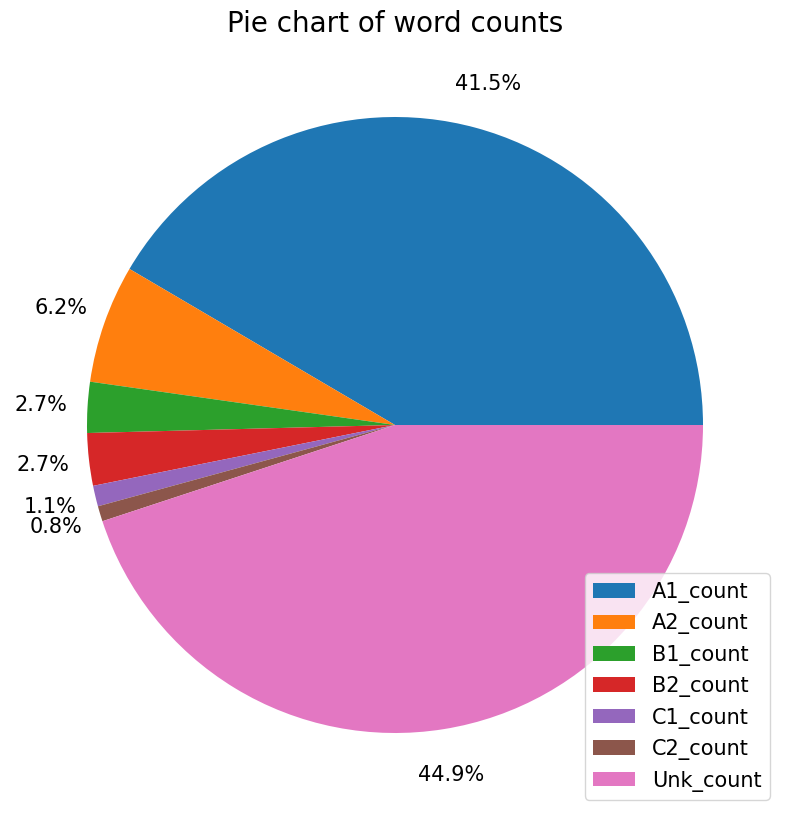

In [84]:
levels = ['A2', 'B1', 'B2']
plt.figure(figsize=(10,10))
plt.rc('font', size=15)
plt.pie(df[['A1_count', 'A2_count', 'B1_count', 'B2_count', 'C1_count', 'C2_count', 'Unk_count']].sum(), autopct='%1.1f%%', pctdistance=1.15)
plt.legend(['A1_count', 'A2_count', 'B1_count', 'B2_count', 'C1_count', 'C2_count', 'Unk_count'])
plt.title('Pie chart of word counts', size=20)
plt.show()

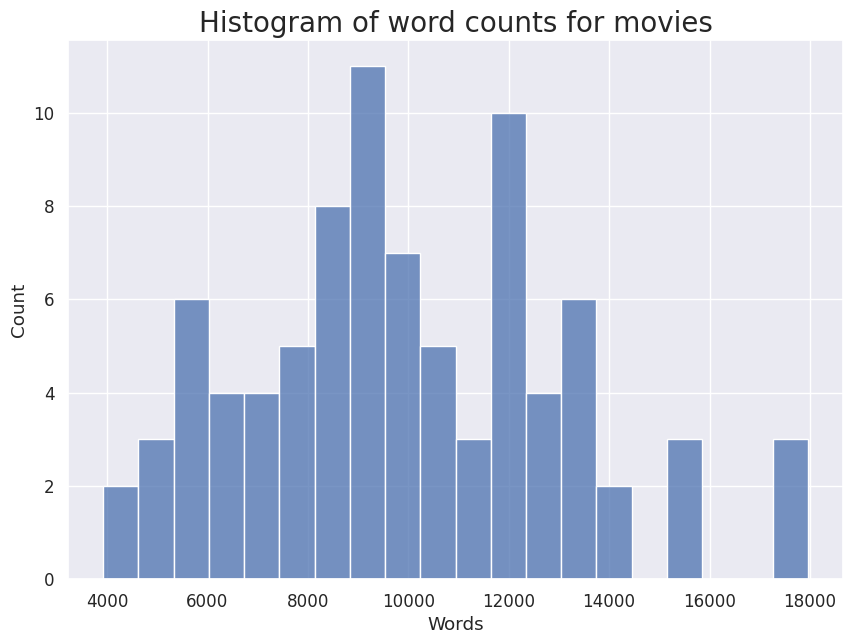

In [85]:
sns.set(font_scale=1.1)
plt.figure(figsize=(10,7))
sns.histplot(df['word_count'], bins=20)
plt.title('Histogram of word counts for movies', size=20)
plt.xlabel('Words')
plt.show()

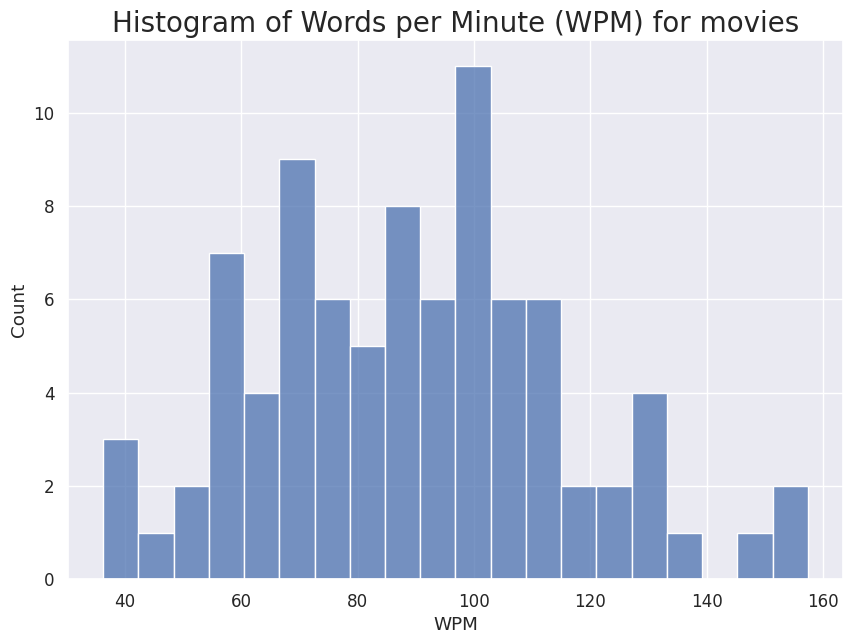

In [86]:
plt.figure(figsize=(10,7))
sns.histplot(df['wpm'], bins=20)
plt.title('Histogram of Words per Minute (WPM) for movies', size=20)
plt.xlabel('WPM')
plt.show()

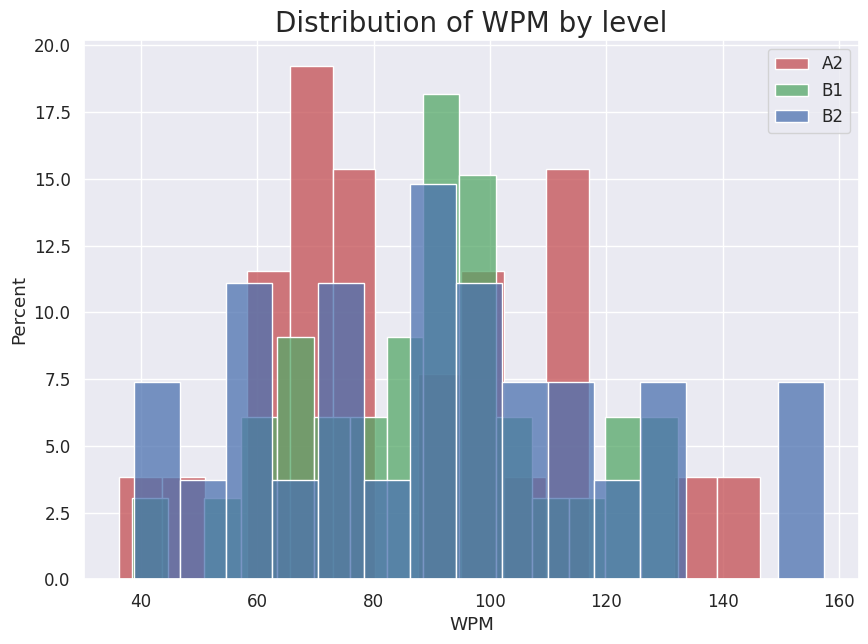

In [87]:
fig, ax = plt.subplots(figsize=(10,7))
color_ref = {
    'A2': 'r',
    'B1': 'g',
    'B2': 'b'
}
for level in levels:
    sns.histplot(df.query('level == @level')['wpm'], bins=15, kde=False, color=color_ref[level], stat='percent')

plt.legend(['A2', 'B1', 'B2'])
plt.title('Distribution of WPM by level', size=20)
plt.xlabel('WPM')
plt.show()

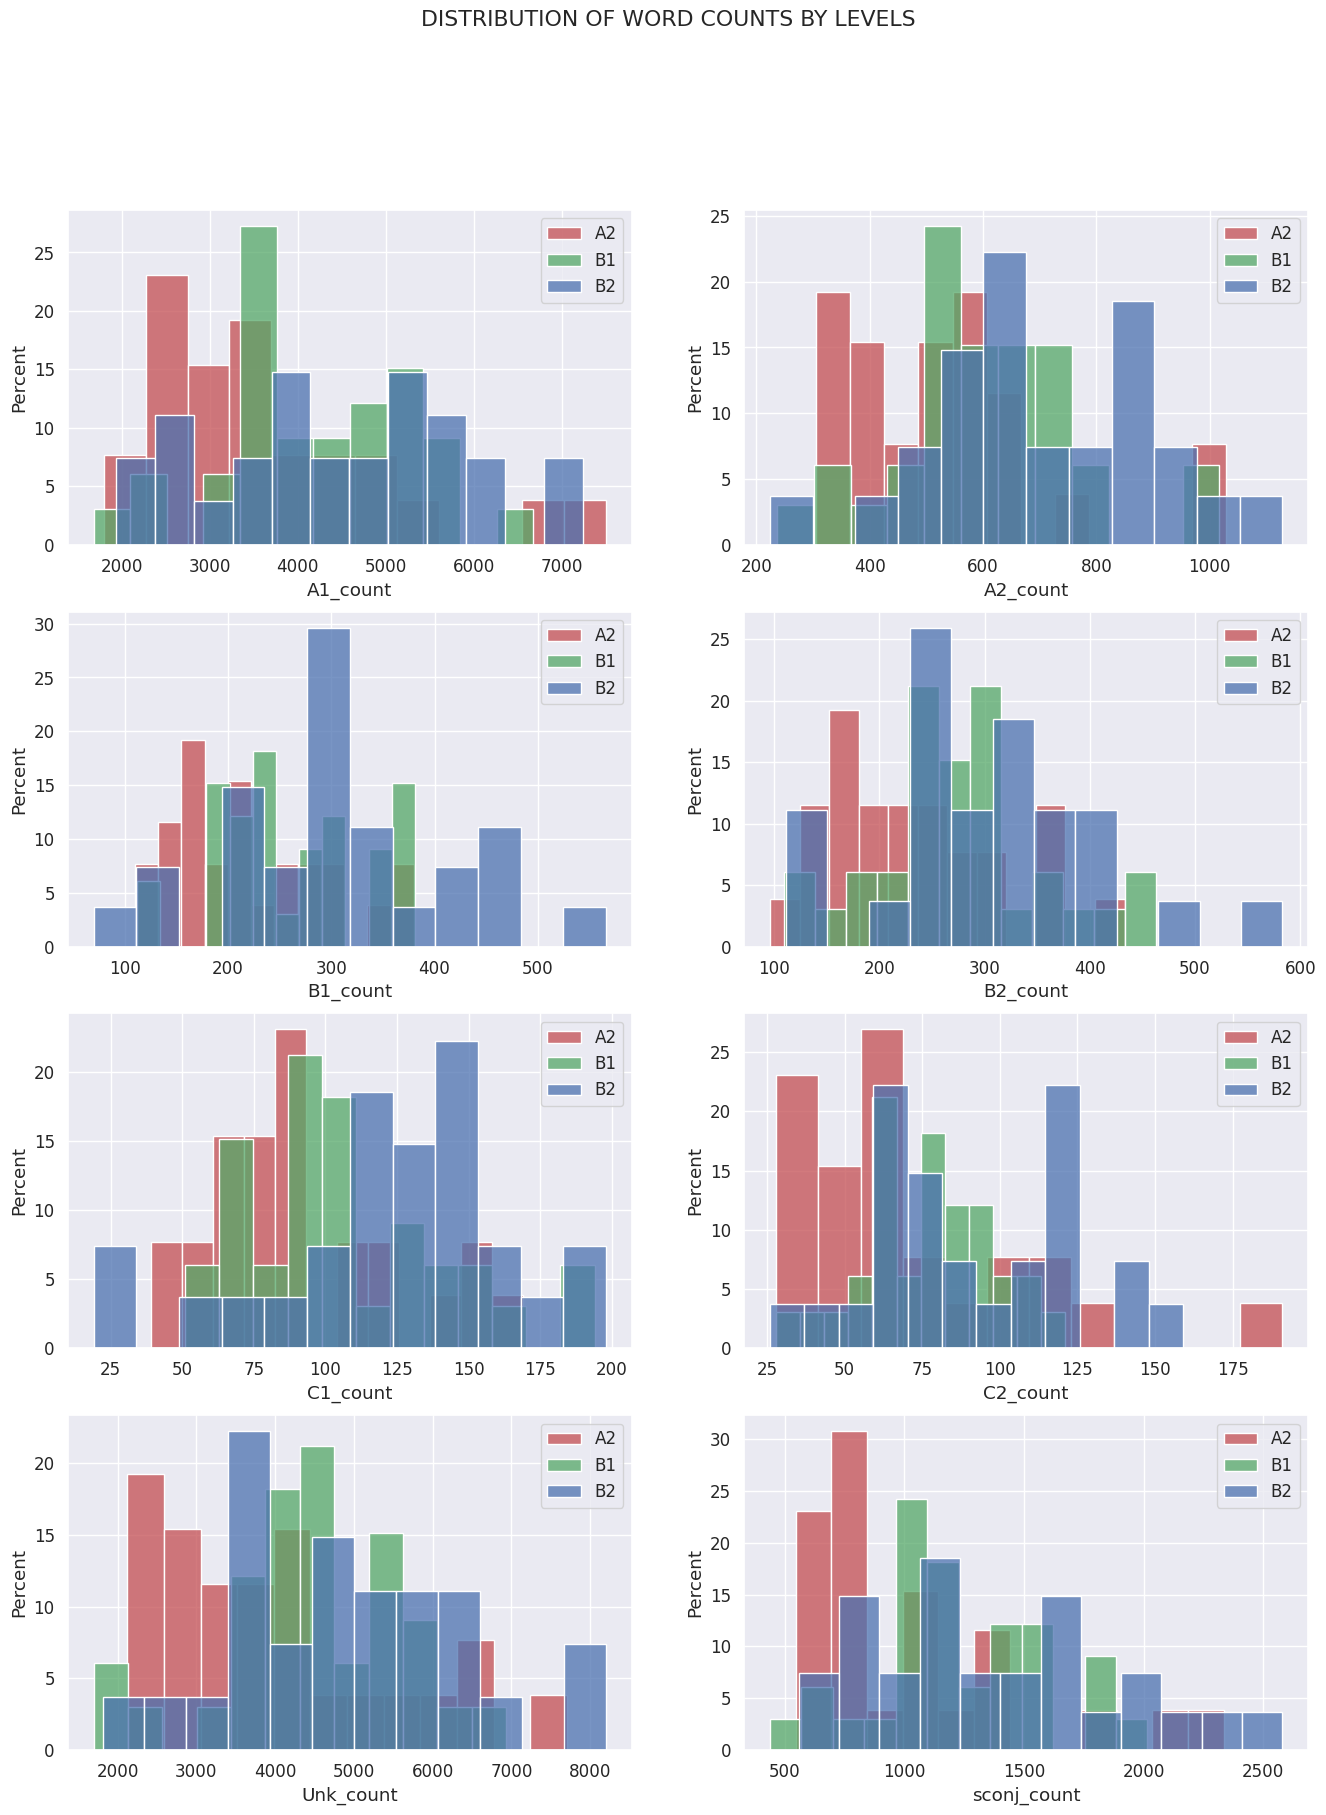

In [88]:
fig, axes = plt.subplots(4,2,figsize=(16,20))
color_ref = {
    'A2': 'r',
    'B1': 'g',
    'B2': 'b'
}

matri  = [
          ['A1_count', 'A2_count'],
          ['B1_count', 'B2_count'],
          ['C1_count', 'C2_count'],
          ['Unk_count', 'sconj_count']
        ]

for i in range(4):
    for j in range(len(matri[i])):
        for level in levels:
            sns.histplot(df.query('level == @level')[matri[i][j]], bins=12, kde=False, color=color_ref[level], ax=axes[i, j], stat='percent')
            axes[i,j].legend(levels)

plt.suptitle('Distribution of word counts by levels'.upper())
plt.show()

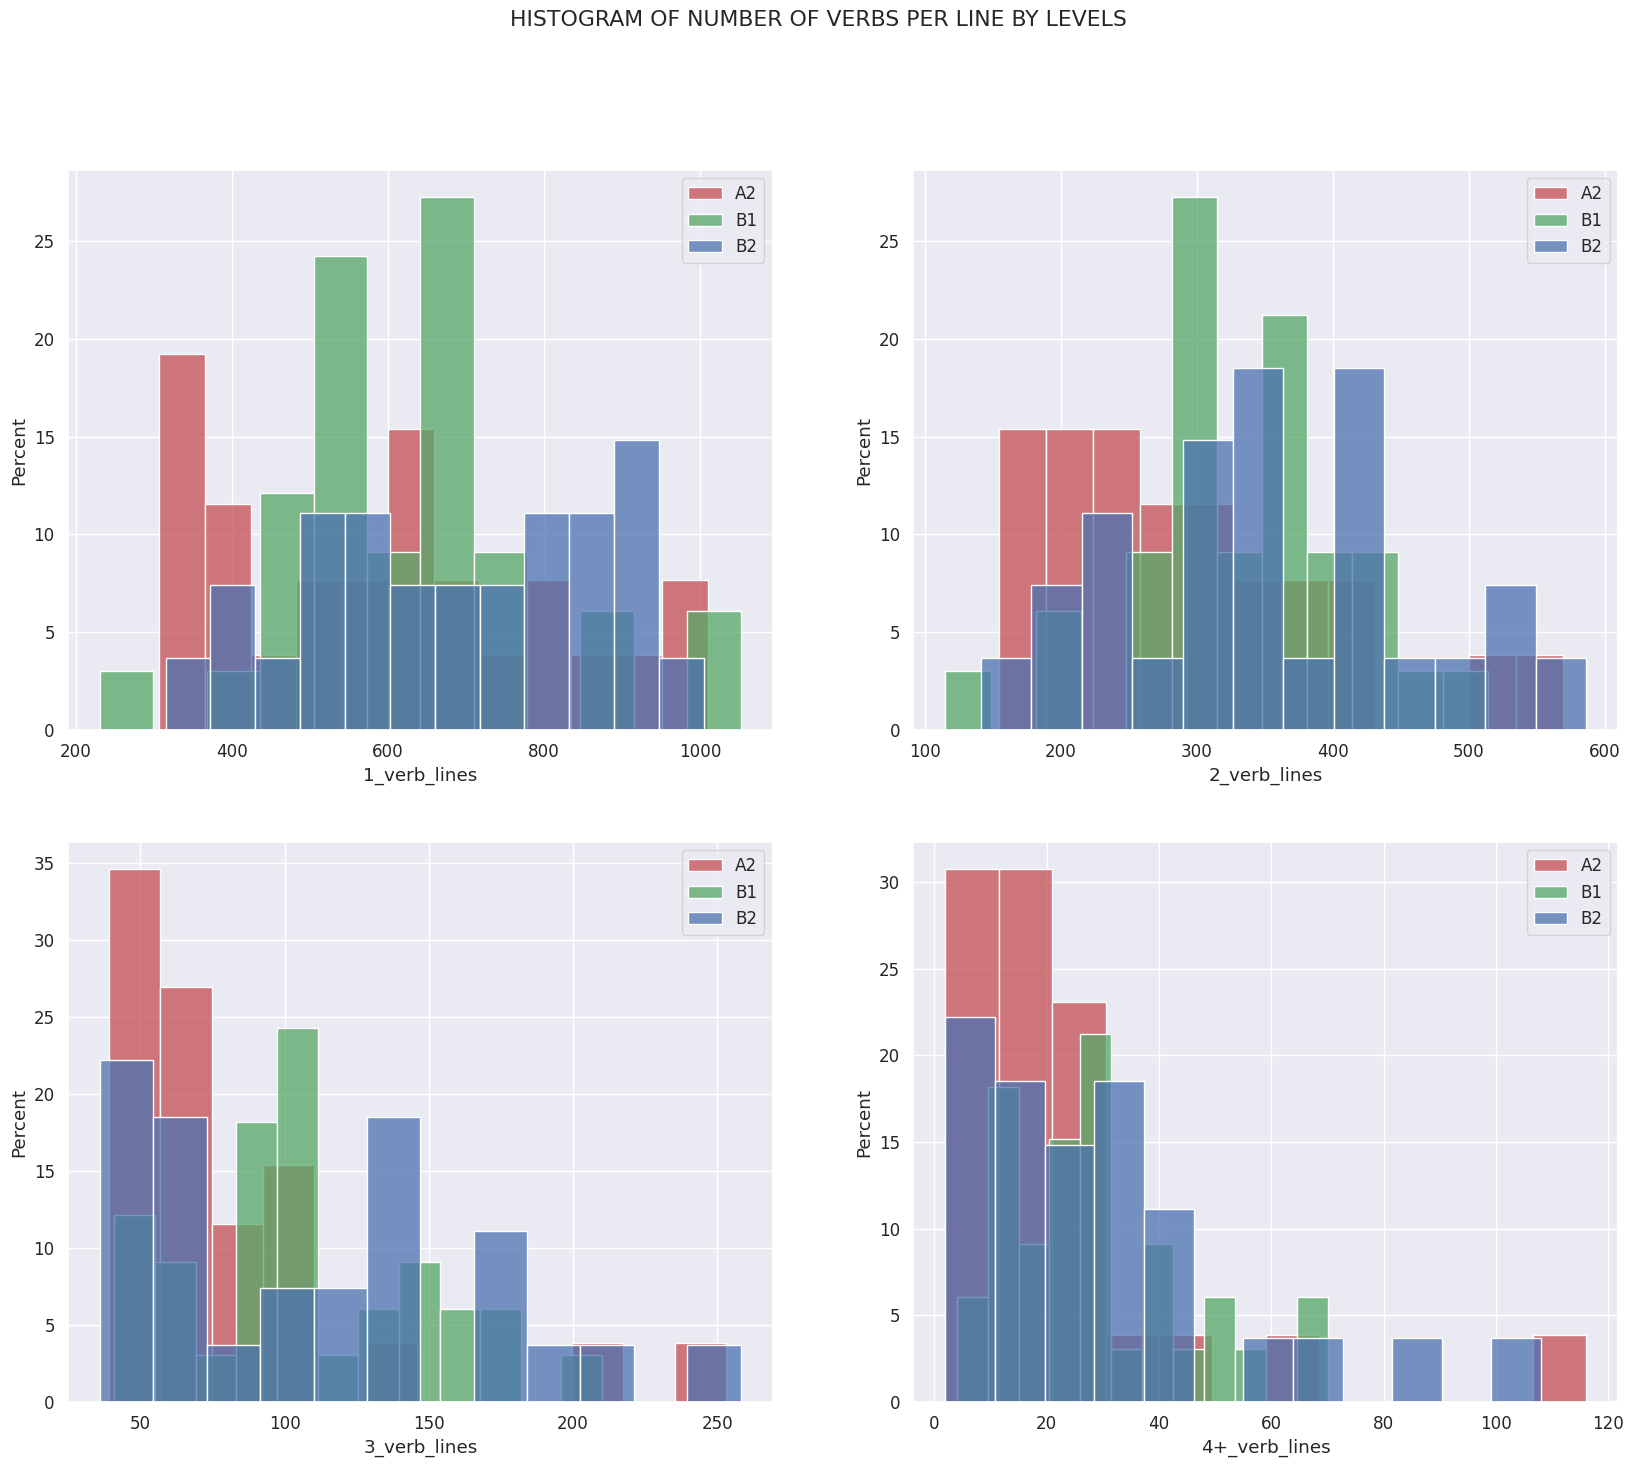

In [89]:
fig, axes = plt.subplots(2,2,figsize=(20,16))
color_ref = {
    'A2': 'r',
    'B1': 'g',
    'B2': 'b'
}
matri  = [
          ['1_verb_lines', '2_verb_lines'],
          ['3_verb_lines', '4+_verb_lines']
        ]

for i in range(2):
    for j in range(2):
        for level in levels:
            sns.histplot(df.query('level == @level')[matri[i][j]], bins=12, kde=False, color=color_ref[level], ax=axes[i, j], stat='percent')
            axes[i,j].legend(levels)

plt.suptitle('Histogram of number of verbs per line by levels'.upper())
plt.show()

## Model training

In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier, Pool
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsClassifier
from catboost import utils

import sklearn.metrics as metrics

df = full_df.copy()

# Let's start creating models!

features = [
            'A1_pct',
            'A2_pct',
            'B1_pct',
            'B2_pct',
            'C1_pct',
            'C2_pct',
            'Unk_pct',
            '1_verb_lines',
            '2_verb_lines',
            '3_verb_lines',
            '4+_verb_lines',
            'sconj_count',
            'wpm'
            ]
target = ['level']
target_dummy = ['level_A2', 'level_B1', 'level_B2']

np.random.seed(1995)

df = df[features+['level']]
df = df.sample(frac=1)
df

,A1_pct,A2_pct,B1_pct,B2_pct,C1_pct,C2_pct,Unk_pct,1_verb_lines,2_verb_lines,3_verb_lines,4+_verb_lines,sconj_count,wpm,level
name,,,,,,,,,,,,,,
twilight,43.309896,6.212614,2.32973,2.62357,0.640151,0.80806,44.075979,794,362,71,4,1284,78.687036,A2
mary_poppins_returns,42.203804,7.259676,2.723303,3.42633,0.932435,0.710427,42.744024,1052,473,91,4,2016,107.988812,B1
mrs_doubtfire,42.855951,6.31781,2.503756,2.562177,1.076615,0.742781,43.940911,541,356,158,38,1236,100.211876,B1
the_usual_suspects,42.5023,6.828171,2.851886,2.524788,1.144843,0.817745,43.330267,506,345,128,41,1158,98.851465,B2
mamma_mia,45.450131,6.584442,1.92289,2.563854,0.670098,0.563271,42.245314,676,370,105,32,1620,99.793248,B1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
the_lion_king,38.570517,5.909381,2.373963,2.169751,0.98277,0.727505,49.266114,587,259,39,10,786,89.816584,A2
pleasantville,42.699782,5.289411,2.244622,2.514808,1.028785,0.613114,45.609477,654,307,90,17,1152,82.73105,B1
liar_liar,40.344284,6.594739,2.897321,3.091284,1.127409,0.909201,45.035762,499,284,84,23,1020,100.393509,B1


In [91]:
def split_df(df, train=3, valid=1, test=1):
    split_size = int(df.shape[0]/(train+valid+test))
    train_df = df[0 : train*split_size].reset_index(drop=True)
    valid_df = df[train*split_size+1 : (train+valid)*split_size].reset_index(drop=True)
    test_df = df[(train+valid)*split_size+1 : df.shape[0]].reset_index(drop=True)
    return train_df, valid_df, test_df

train_df, valid_df, test_df = split_df(df)

print('Splitting dataframes in proportion: 3, 1')
print('Train dataframe size:', train_df.shape[0])
print('Test dataframe size:', test_df.shape[0])

Splitting dataframes in proportion: 3, 1
Train dataframe size: 51
Test dataframe size: 17


In [92]:
target_dummy=target
train_feat = train_df[features].reset_index(drop=True)
train_targ = train_df[target_dummy].reset_index(drop=True)

test_feat = test_df[features].reset_index(drop=True)
test_targ = test_df[target_dummy].reset_index(drop=True)

In [93]:
classifier = CatBoostClassifier(random_state=1995, verbose=False)
eval_dataset = Pool(test_feat, test_targ)
cat_dict = {
    'depth': [5, 10, 20],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'iterations': [100, 300, 500]
}

In [94]:
from google.colab import output
output.enable_custom_widget_manager()

In [95]:
train_targ

,level
0,A2
1,B1
2,B1
3,B2
4,B1
5,B2
6,A2
7,A2
8,A2
9,B1


In [96]:
%%time
results = classifier.grid_search(cat_dict, X=train_feat, y=train_targ, cv=3, verbose=False)


bestTest = 1.055933313
bestIteration = 97


bestTest = 0.946778261
bestIteration = 89


bestTest = 1.011587248
bestIteration = 34


bestTest = 1.007467895
bestIteration = 7


bestTest = 0.9996790404
bestIteration = 299


bestTest = 0.946778261
bestIteration = 89


bestTest = 1.011587248
bestIteration = 34


bestTest = 1.007467895
bestIteration = 7


bestTest = 0.9610249284
bestIteration = 486


bestTest = 0.946778261
bestIteration = 89


bestTest = 1.011587248
bestIteration = 34


bestTest = 1.007467895
bestIteration = 7


bestTest = 1.083923517
bestIteration = 99


bestTest = 1.019715715
bestIteration = 81


bestTest = 1.027446885
bestIteration = 3


bestTest = 0.8610247543
bestIteration = 28


bestTest = 1.064266939
bestIteration = 251


bestTest = 1.019715715
bestIteration = 81


bestTest = 1.027446885
bestIteration = 3


bestTest = 0.8610247543
bestIteration = 28


bestTest = 1.055150369
bestIteration = 498


bestTest = 1.019715715
bestIteration = 81


bestTest = 1.027446885
bestI

In [97]:
accuracy = classifier.score(test_feat, test_targ)
accuracy

0.6470588235294118

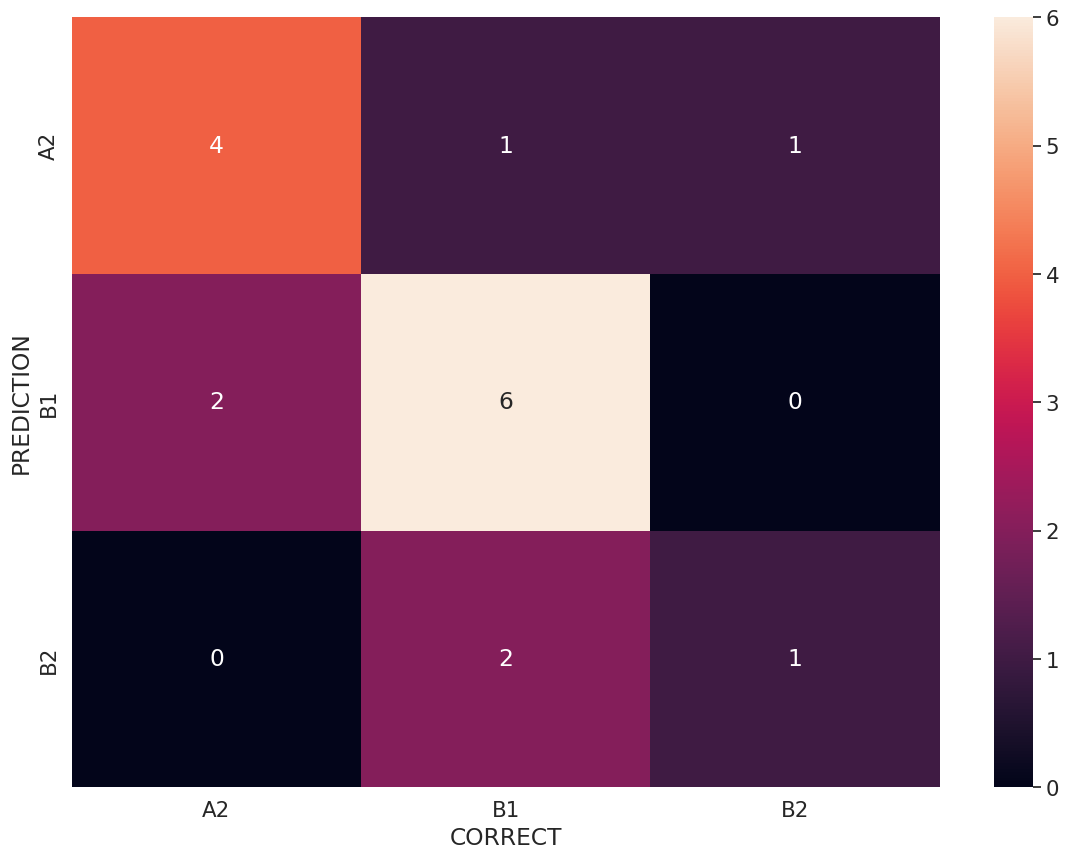

In [98]:
plt.figure(figsize=(14,10))
sns.set(font_scale=1.4)
sns.heatmap(utils.get_confusion_matrix(classifier, eval_dataset), xticklabels=levels, yticklabels=levels, annot=True, )
plt.ylabel('PREDICTION')
plt.xlabel('CORRECT')
plt.show()